In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = './tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [4]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [5]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [6]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                              

In [7]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [8]:
import os

base_dir = './'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/train'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/validation'))

Contents of base directory:
['cat-dog-augmentation.ipynb', 'cat-dog-inception.ipynb', 'cat-dog.ipynb', 'input_dir', 'sampleSubmission.csv', 'test1', 'tmp', 'train', 'train.zip', 'validation']

Contents of train directory:
['cats', 'dogs']

Contents of validation directory:
['cats', 'dogs']


In [9]:
import os

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


In [10]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.1000.jpg', 'cat.10000.jpg', 'cat.10001.jpg', 'cat.10002.jpg', 'cat.10003.jpg', 'cat.10004.jpg', 'cat.10005.jpg', 'cat.10006.jpg', 'cat.10007.jpg', 'cat.10008.jpg']
['dog.1000.jpg', 'dog.10000.jpg', 'dog.10001.jpg', 'dog.10002.jpg', 'dog.10003.jpg', 'dog.10004.jpg', 'dog.10005.jpg', 'dog.10006.jpg', 'dog.10007.jpg', 'dog.10008.jpg']


In [11]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 11500
total training dog images : 11500
total validation cat images : 1000
total validation dog images : 1000


In [12]:


from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))



Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [13]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 64s - loss: 0.3587 - accuracy: 0.8535 - val_loss: 0.1219 - val_accuracy: 0.9540 - 64s/epoch - 637ms/step
Epoch 2/20
100/100 - 46s - loss: 0.2355 - accuracy: 0.9055 - val_loss: 0.2445 - val_accuracy: 0.9220 - 46s/epoch - 463ms/step
Epoch 3/20
100/100 - 43s - loss: 0.2131 - accuracy: 0.9195 - val_loss: 0.0960 - val_accuracy: 0.9660 - 43s/epoch - 427ms/step
Epoch 4/20
100/100 - 35s - loss: 0.1952 - accuracy: 0.9270 - val_loss: 0.1169 - val_accuracy: 0.9580 - 35s/epoch - 345ms/step
Epoch 5/20
100/100 - 37s - loss: 0.2035 - accuracy: 0.9270 - val_loss: 0.1186 - val_accuracy: 0.9580 - 37s/epoch - 369ms/step
Epoch 6/20
100/100 - 33s - loss: 0.2053 - accuracy: 0.9200 - val_loss: 0.1404 - val_accuracy: 0.9520 - 33s/epoch - 335ms/step
Epoch 7/20
100/100 - 31s - loss: 0.2014 - accuracy: 0.9275 - val_loss: 0.1133 - val_accuracy: 0.9630 - 31s/epoch - 307ms/step
Epoch 8/20
100/100 - 29s - loss: 0.1950 - accuracy: 0.9265 - val_loss: 0.1160 - val_accuracy: 0.9600 - 29s/epoch - 293

In [15]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

# Directory with unput pictures
input_dir = os.path.join('./input_dir/')

input_names = os.listdir(input_dir)

for fn in input_names:
    
    #predicting images
    path = input_dir + fn
    img = load_img(path, target_size=(150, 150))
    x = img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
        print(fn + " is a dog")
    else:
        print(fn + " is a cat")

1/1 [==============================] - 1s 1s/step
[1.]
1.jpg is a dog
1/1 [==============================] - 0s 25ms/step
[0.00013167]
10.jpg is a cat
1/1 [==============================] - 0s 25ms/step
[1.3952287e-13]
11.jpg is a cat
1/1 [==============================] - 0s 27ms/step
[1.]
12.jpg is a dog
1/1 [==============================] - 0s 26ms/step
[1.5674082e-14]
13.jpg is a cat
1/1 [==============================] - 0s 29ms/step
[0.00449205]
14.jpg is a cat
1/1 [==============================] - 0s 29ms/step
[5.3010405e-09]
15.jpg is a cat
1/1 [==============================] - 0s 31ms/step
[2.7795896e-10]
16.jpg is a cat
1/1 [==============================] - 0s 28ms/step
[1.]
17.jpg is a dog
1/1 [==============================] - 0s 31ms/step
[1.]
18.jpg is a dog
1/1 [==============================] - 0s 28ms/step
[6.7070203e-18]
19.jpg is a cat
1/1 [==============================] - 0s 28ms/step
[1.]
2.jpg is a dog
1/1 [==============================] - 0s 25ms/step
[2.59

Text(0.5, 1.0, 'Training and validation loss')

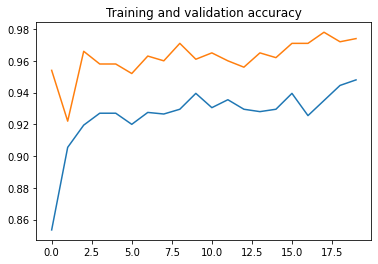

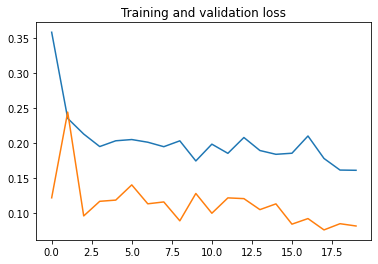

In [20]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )